In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import gymnasium as gym

from typing import Tuple, List, Type

In [2]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.legend(handles=h_list)
    plt.show()

# Q2: Backjack 

Please note, since there is no scaffolding code for this question. Please make sure your implementation is well-tested and the comments are clear to understand. 

In [210]:
# test code for using the "Backjack" implementation from OpenAI
env = gym.make("Blackjack-v1", sab=True)
env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    action = env.action_space.sample()
    
    # interact with the envrionment
    next_s, reward, done, info, _ = env.step(action)
    
    # print info
    print(f"t = {t}, next_state = {next_s}, reward = {reward}, done = {done}")
    
    # check termination
    if done:
        env.reset()

t = 0, next_state = (21, 8, 1), reward = 0.0, done = False
t = 1, next_state = (21, 8, 1), reward = 1.0, done = True
t = 2, next_state = (13, 8, 0), reward = -1.0, done = True
t = 3, next_state = (6, 6, 0), reward = -1.0, done = True
t = 4, next_state = (6, 10, 0), reward = -1.0, done = True
t = 5, next_state = (22, 4, 0), reward = -1.0, done = True
t = 6, next_state = (20, 3, 0), reward = 1.0, done = True
t = 7, next_state = (14, 8, 0), reward = -1.0, done = True
t = 8, next_state = (14, 10, 0), reward = -1.0, done = True
t = 9, next_state = (18, 6, 1), reward = 1.0, done = True


## (a): Implement first-visit Monte-Carlo policy evaluation (See pseudocode in 5.1). 

Please read Example 5.1 and reproduce Figure 1. The policy to be evaluated is the "sticks only on 20 or 21". Please only reproduce the plots after 500, 000 episodes (Usable ace and No usable ace). 

In [88]:
# action space: 0 = stick, 1 = hit
# policy: stick if player's sum is 20 or 21, else hit

GAMMA = 1 # no discounting

usable_ace_value = [[[0] for _ in range(10)] for _ in range(21)]
no_usable_ace_value = [[[0] for _ in range(10)] for _ in range(21)]

for _ in range(500000):

    # store states and rewards for the episode
    state_list = []
    reward_list = []
    
    # generate an episode
    state, _ = env.reset()
    done = False
    while not done:
        if state[0] >= 20: # player's sum is 20 or 21
            action = 0 # stick
        else:
            action = 1 # hit
            
        next_s, reward, done, _, _ = env.step(action)
        
        state_list.append(state)
        reward_list.append(reward)

        state = next_s

    g = 0
    # loop through states and rewards backwards
    for state, reward in zip(state_list[::-1], reward_list[::-1]):
        g = GAMMA*g + reward 
        # in blackjack every visit and first visit are the same, so can skip the check of "unless St appears in S0, ...St-1"
        if state[2] == 1:
            usable_ace_value[state[0]-1][state[1]-1].append(g)
        else:
            no_usable_ace_value[state[0]-1][state[1]-1].append(g)
        
        

Text(0.5, 0.92, 'no usable ace')

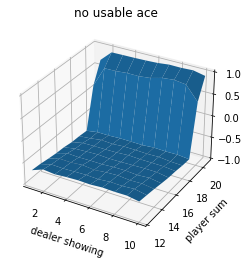

In [89]:
z = np.array([[np.mean(a) for a in b] for b in no_usable_ace_value])
z = z[11:, :]

x = np.arange(1, len(z)+1)
y = np.arange(12, len(z[0])+12)

(x, y) = np.meshgrid(x, y)

ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z)
ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_ylim([12, 21])
ax.set_zlim([-1, 1])
ax.set_title("no usable ace")

Text(0.5, 0.92, 'usable ace')

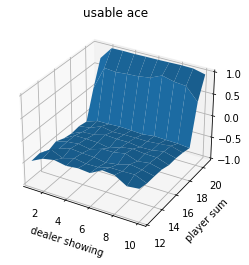

In [91]:
z = np.array([[np.mean(a) for a in b] for b in usable_ace_value])
z = z[11:, :]

x = np.arange(1, len(z)+1)
y = np.arange(12, len(z[0])+12)

(x, y) = np.meshgrid(x, y)

ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z)
ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_ylim([12, 21])
ax.set_zlim([-1, 1])
ax.set_title("usable ace")

## (b): Implement first-visit Monte-Carlo control with exploring starts (Monte-Carlo ES in 5.3). 

Please read the Example 5.1 and reproduce the Figure 5.2

In [211]:
# action space: 0 = stick, 1 = hit
# policy: stick if player's sum is 20 or 21, else hit

# initialize policy that hits for player's sum under 20 and sticks otherwise
# policy[0] is the policy map for no usable ace, policy[1] is the policy map for usable ace
policy = [[[1 for _ in range(10)] for _ in range(19)] + [[0 for _ in range(10)] for _ in range(2)] for _ in range(2)]

# state action values in form V(state, action) = avg(q[action][state0][state1])
q_usable_ace = [[[[0] for _ in range(10)] for _ in range(21)] for _ in range(2)]
q_no_usable_ace = [[[[0] for _ in range(10)] for _ in range(21)] for _ in range(2)]

GAMMA = 1 # no discounting

def set_policy(policy_arr: List[List[List[int]]], state: List[int], policy: int) -> List[List[List[int]]]:
    """Sets deterministic policy.

    Args:
        policy_arr: array of policies in list form, where value of array indexed by state is the index of an action
        state: current state
        policy: index of action to set policy at state to

    Returns:
        policy_arr: updated policy array
    """
    policy_arr[state[2]][state[0]-1][state[1]-1] = policy
    return policy_arr

def get_policy(policy_arr: List[List[List[int]]], state: List[int]) -> List[List[List[int]]]:
    """Gets policy at state.

    Args:
        policy_arr: array of policies in list form, where value of array indexed by state is the index of an action
        state: current state

    Returns:
        policy in form of index of action at the current state
    """
    return policy_arr[state[2]][state[0]-1][state[1]-1]

def get_value(q: List[List[List[int]]], state: List[int], action: int) -> float:
    """Gets state action value at state/action.

    Args:
        q: array of state action in list form, where value of array indexed by state is the list of all previous rewards (since no discounting)
        state: current state
        action: index of action

    Returns:
        state action value at the given state/action
    """
    return np.mean(q[action][state[0]-1][state[1]-1])
    
for _ in range(500000):

    # store states and rewards for the episode
    state_list = []
    reward_list = []
    action_list = []
    
    # generate an episode
    state, _ = env.reset()
    # state = (np.random.randint(1, 22), np.random.randint(1, 11), np.random.randint(0, 1))
    action = np.random.choice([0, 1])
    done = False
    while not done:
        # find action according to current policy
        
        next_s, reward, done, _, _ = env.step(action)
        
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)

        state = next_s
        if not done:
            action = get_policy(policy, state)

    g = 0
    # loop through states and rewards backwards
    for state, action, reward in zip(state_list[::-1], action_list[::-1], reward_list[::-1]):
        g = GAMMA*g + reward 
        # in blackjack every visit and first visit are the same, so can skip the check of "unless St appears in S0, ...St-1"
        if state[2] == 1:
            q_usable_ace[action][state[0]-1][state[1]-1].append(g)

            p = np.argmax([get_value(q_usable_ace, state, 0), get_value(q_usable_ace, state, 1)])
            set_policy(policy, state, p)
        else:
            q_no_usable_ace[action][state[0]-1][state[1]-1].append(g)

            p = np.argmax([get_value(q_no_usable_ace, state, 0), get_value(q_no_usable_ace, state, 1)])
            set_policy(policy, state, p)

Text(0.5, 0.92, 'value function - no usable ace')

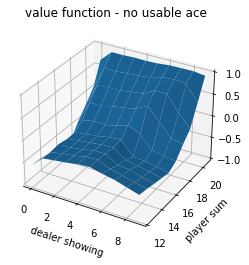

In [214]:
z = np.array([[[np.mean(a) for a in b] for b in c] for c in q_no_usable_ace])
z = z.max(axis=0)
z = z[11:, :]

y = np.arange(12, 12+len(z))
x = np.arange(len(z[0]))

(x, y) = np.meshgrid(x, y)

ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z)
ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_ylim([12, 21])
ax.set_zlim([-1, 1])
ax.set_title("value function - no usable ace")

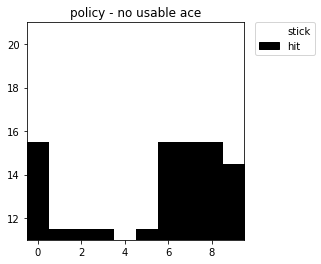

In [225]:
plt.imshow(policy[0], origin='upper', cmap=plt.colormaps['Greys'])
plt.ylim([11, 21])
plt.title("policy - no usable ace")
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['white', 'black'], ['stick', 'hit'])]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

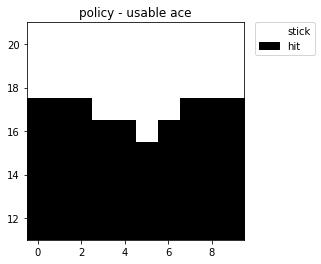

In [226]:
plt.imshow(policy[1], origin='upper', cmap=plt.colormaps['Greys'])
plt.ylim([11, 21])
plt.title("policy - usable ace")
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['white', 'black'], ['stick', 'hit'])]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

Text(0.5, 0.92, 'usable ace')

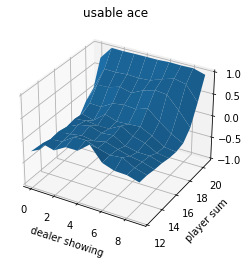

In [227]:
z = np.array([[[np.mean(a) for a in b] for b in c] for c in q_usable_ace])
z = z.max(axis=0)
z = z[11:, :]

y = np.arange(12, 12+len(z))
x = np.arange(len(z[0]))

(x, y) = np.meshgrid(x, y)

ax = plt.axes(projection="3d")
ax.plot_surface(x, y, z)
ax.set_xlabel("dealer showing")
ax.set_ylabel("player sum")
ax.set_ylim([12, 21])
ax.set_zlim([-1, 1])
ax.set_title("usable ace")

# Q3: Four Rooms, re-visited

In [74]:
"""DO NOT CHANGE"""
class FourRooms(object):
    def __init__(self):
        # define the four room as a 2-D array for easy state space reference and visualization
        # 0 represents an empty cell; 1 represents a wall cell
        self.four_room_space = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # find the positions for all empty cells
        # note that: the origin for a 2-D numpy array is located at top-left while the origin for the FourRooms is at
        # the bottom-left. The following codes performs the re-projection.
        empty_cells = np.where(self.four_room_space == 0.0)
        self.state_space = [[col, 10 - row] for row, col in zip(empty_cells[0], empty_cells[1])]

        # define the action space
        self.action_space = {'LEFT': np.array([-1, 0]),
                             'RIGHT': np.array([1, 0]),
                             'DOWN': np.array([0, -1]),
                             'UP': np.array([0, 1])}

        # define the start state
        self.start_state = [0, 0]

        # define the goal state
        self.goal_state = [10, 10]

        # maximal time steps
        self.max_time_steps = 459

        # track the time step
        self.t = 0

    def reset(self):
        """
        Reset the agent's state to the start state [0, 0]
        Return both the start state and reward
        """
        # reset the agent state to be [0, 0]
        state = self.start_state
        # reset the reward to be 0
        reward = 0
        # reset the termination flag
        done = False
        # reset the time step tracker
        self.t = 0
        return state, reward, done

    def step(self, state, act):
        """
        Args:
            state: a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act: a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state: a list variable containing x, y integer coordinates (i.e., [1, 1])
            reward: an integer. it can be either 0 or 1.
        """
        # Increase the time step
        self.t += 1

        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if act == "LEFT" or act == "RIGHT":
                act = np.random.choice(["UP", "DOWN"], 1)[0]
            else:
                act = np.random.choice(["RIGHT", "LEFT"], 1)[0]

        # Compute the next state
        next_state = self.take_action(state, act)

        # Compute the reward
        reward = 1.0 if next_state == [10, 10] else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if next_state == [10, 10] or self.t == self.max_time_steps:
            done = True
        else:
            done = False

        return next_state, reward, done

    def take_action(self, state, act):
        """
        Input args:
            state (list): a list variable containing x, y integer coordinates. (i.e., [1, 1]).
            act (string): a string variable (i.e., "UP"). All feasible values are ["UP", "DOWN", "LEFT", "RIGHT"].
        Output args:
            next_state (list): a list variable containing x, y integer coordinates (i.e., [1, 1])
        """
        state = np.array(state)
        next_state = state + self.action_space[act]
        return next_state.tolist() if next_state.tolist() in self.state_space else state.tolist()

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy

In [75]:
""" CODE HERE YOUR IMPLEMENTATION for Q3-(a) """
# Implementation of the one-policy first-vist Monte-Carlo control (for ε-soft policies) here.
# To debug your code, you can use run_num = 5 and episode_num = 1e3
# To report the finial results, please use run_num = 10 and episode_num = 1e4

RUN_NUM = 10
EPISODE_NUM = int(1e4)
env = FourRooms()
ACTIONS = {i: a for i, a in enumerate(env.action_space.keys())}
NUM_ACTIONS = len(env.action_space)
GAMMA = 0.9

def get_value(q: np.array, state: List[int], action: int) -> float:
    """Gets q(s, t) given s and t.

    Args:
        q: np array of state action values
        state: current state
        action: index of action

    Returns:
        q(s, a)
    """
    return q[tuple(state + [action])]
    
def add_value(q: np.array, counter: np.array, state: List[int], action: int, value: float) -> Tuple[np.array, np.array]:
    """Updates state action value array with new value

    Args:
        q: np array of state action values
        counter: np array of number of times each state/action pair has been visited
        state: current state
        action: index of action
        value: value to update q with

    Returns:
        q: updated state action value array
        counter: updated counter array
    """
    index = tuple(state + [action])
    counter[index] = counter[index] + 1
    q[index] = (q[index] * (counter[index] - 1) + value) / counter[index]
    return q, counter

def set_policy(policy_arr: np.array, state: List[int], action: int, policy: float) -> np.array:
    """Sets stochastic policy value for state/action pair.

    Args:
        policy_arr: np array of policy where policy_arr[state, action] gives the probability of that action occuring for that state
        state: current state
        action: index of action
        policy: new value for the policy at the state/action pair

    Returns: 
        policy_arr: updated policy array
    """
    policy_arr[tuple(state + [action])] = policy
    return policy_arr

def get_policy(policy_arr: np.array, state: List[int]) -> int:
    """Gets action based on stochastic policy.

    Args:
        policy_arr: np array of policy where policy_arr[state, action] gives the probability of that action occuring for that state
        state: current state

    Returns:
        a: action determined from stochastic policy
    """
    r = np.random.rand()

    chance = 0
    for a in range(policy_arr.shape[-1]):
        chance += policy_arr[tuple(state + [a])]

        if r <= chance:
            return a

def argmax(l: List[float]) -> int:
    """Argmax function with ties broken randomly.

    Args:
        l: list or list-like

    Returns:
        index of max value
    """    l = np.array(l)
    return np.random.choice(np.flatnonzero(l == l.max()))

def run_mc_e_soft(env: Type[FourRooms], epsilon: float, num_runs: int=RUN_NUM, num_episodes: int=EPISODE_NUM) -> np.array:
    """Runs e-soft MC policy for FourRooms env

    Args:
        env: FourRooms environment
        epsilon: epsilon value to use for policy
        num_runs: number of runs
        num_episodes: number of episodes per run

    Returns:
        results_rewards: np array of discounted reward for each episode
    """
    results_rewards = np.empty((num_runs, num_episodes))
    
    for r in range(num_runs):
        print(f"r: {r}")
        
        # initialize policy to equal chance for everything
        policy = np.ones(list(env.four_room_space.shape) + [NUM_ACTIONS]) * (1/NUM_ACTIONS)
        q = np.zeros(list(env.four_room_space.shape) + [NUM_ACTIONS])
        counter = np.zeros(list(env.four_room_space.shape) + [NUM_ACTIONS])
            
        for e in range(num_episodes):
    
            if e%100 == 0:
                print(f"e: {e}")
        
            # store states and rewards for the episode
            state_action_list = []
            reward_list = []
            
            # generate an episode
            state, reward, done = env.reset()
            while not done:
                # find action according to current policy
                action = get_policy(policy, state)
                
                next_s, reward, done, = env.step(state, ACTIONS[action])
                
                state_action_list.append((state, action))
                reward_list.append(reward)
        
                state = next_s
        
            g = 0
            t = len(state_action_list)-1
            # loop through states and rewards backwards
            for state_action, reward in zip(state_action_list[::-1], reward_list[::-1]):
                state = state_action[0]
                action = state_action[1]
                
                g = GAMMA*g + reward
        
                if state_action not in state_action_list[:t]: # first-visit
                    q, counter = add_value(q, counter, state, action, g)
    
                    # find optimal action
                    a_star = argmax([get_value(q, state, a) for a in range(NUM_ACTIONS)])
    
                    # update policy 
                    for a in range(len(env.action_space)):
                        if a == a_star:
                            policy = set_policy(policy, state, a, 1-epsilon+(epsilon/NUM_ACTIONS))
                        else:
                            policy = set_policy(policy, state, a, epsilon/NUM_ACTIONS)
                t -= 1
                results_rewards[r, e] = g

    return results_rewards

In [76]:
env = FourRooms()
results_rewards = run_mc_e_greedy(env, 0.1)

r: 0
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 2600
e: 2700
e: 2800
e: 2900
e: 3000
e: 3100
e: 3200
e: 3300
e: 3400
e: 3500
e: 3600
e: 3700
e: 3800
e: 3900
e: 4000
e: 4100
e: 4200
e: 4300
e: 4400
e: 4500
e: 4600
e: 4700
e: 4800
e: 4900
e: 5000
e: 5100
e: 5200
e: 5300
e: 5400
e: 5500
e: 5600
e: 5700
e: 5800
e: 5900
e: 6000
e: 6100
e: 6200
e: 6300
e: 6400
e: 6500
e: 6600
e: 6700
e: 6800
e: 6900
e: 7000
e: 7100
e: 7200
e: 7300
e: 7400
e: 7500
e: 7600
e: 7700
e: 7800
e: 7900
e: 8000
e: 8100
e: 8200
e: 8300
e: 8400
e: 8500
e: 8600
e: 8700
e: 8800
e: 8900
e: 9000
e: 9100
e: 9200
e: 9300
e: 9400
e: 9500
e: 9600
e: 9700
e: 9800
e: 9900
r: 1
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 260

In [78]:
results_rewards_2 = run_mc_e_greedy(env, 0.01)

r: 0
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 2600
e: 2700
e: 2800
e: 2900
e: 3000
e: 3100
e: 3200
e: 3300
e: 3400
e: 3500
e: 3600
e: 3700
e: 3800
e: 3900
e: 4000
e: 4100
e: 4200
e: 4300
e: 4400
e: 4500
e: 4600
e: 4700
e: 4800
e: 4900
e: 5000
e: 5100
e: 5200
e: 5300
e: 5400
e: 5500
e: 5600
e: 5700
e: 5800
e: 5900
e: 6000
e: 6100
e: 6200
e: 6300
e: 6400
e: 6500
e: 6600
e: 6700
e: 6800
e: 6900
e: 7000
e: 7100
e: 7200
e: 7300
e: 7400
e: 7500
e: 7600
e: 7700
e: 7800
e: 7900
e: 8000
e: 8100
e: 8200
e: 8300
e: 8400
e: 8500
e: 8600
e: 8700
e: 8800
e: 8900
e: 9000
e: 9100
e: 9200
e: 9300
e: 9400
e: 9500
e: 9600
e: 9700
e: 9800
e: 9900
r: 1
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 260

In [79]:
results_rewards_3 = run_mc_e_greedy(env, 0)

r: 0
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 2600
e: 2700
e: 2800
e: 2900
e: 3000
e: 3100
e: 3200
e: 3300
e: 3400
e: 3500
e: 3600
e: 3700
e: 3800
e: 3900
e: 4000
e: 4100
e: 4200
e: 4300
e: 4400
e: 4500
e: 4600
e: 4700
e: 4800
e: 4900
e: 5000
e: 5100
e: 5200
e: 5300
e: 5400
e: 5500
e: 5600
e: 5700
e: 5800
e: 5900
e: 6000
e: 6100
e: 6200
e: 6300
e: 6400
e: 6500
e: 6600
e: 6700
e: 6800
e: 6900
e: 7000
e: 7100
e: 7200
e: 7300
e: 7400
e: 7500
e: 7600
e: 7700
e: 7800
e: 7900
e: 8000
e: 8100
e: 8200
e: 8300
e: 8400
e: 8500
e: 8600
e: 8700
e: 8800
e: 8900
e: 9000
e: 9100
e: 9200
e: 9300
e: 9400
e: 9500
e: 9600
e: 9700
e: 9800
e: 9900
r: 1
e: 0
e: 100
e: 200
e: 300
e: 400
e: 500
e: 600
e: 700
e: 800
e: 900
e: 1000
e: 1100
e: 1200
e: 1300
e: 1400
e: 1500
e: 1600
e: 1700
e: 1800
e: 1900
e: 2000
e: 2100
e: 2200
e: 2300
e: 2400
e: 2500
e: 260

<Figure size 432x288 with 0 Axes>

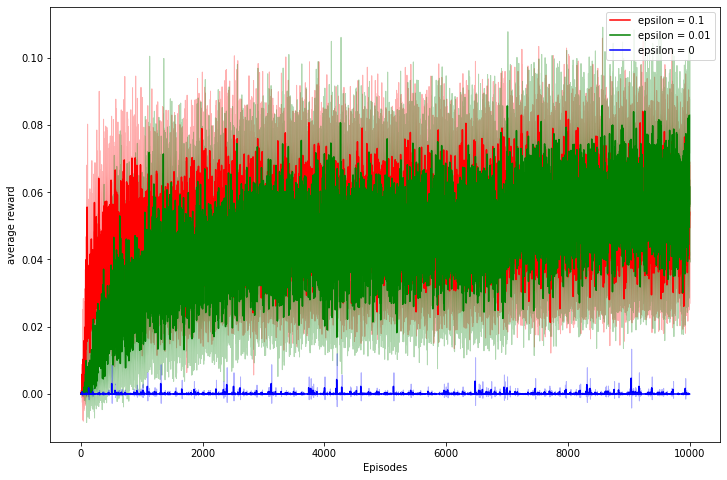

In [88]:
plot_curves([results_rewards, results_rewards_2, results_rewards_3], ['epsilon = 0.1', 'epsilon = 0.01', 'epsilon = 0'], ['r', 'g', 'b'], 'average reward')

## Q5: Racktrack

Please note, we provde you with the implementation of the two Racetrack domains in the Figure 5.5.

In [3]:
# Define the Racetrack domain 1
racetrack_v1_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]])

racetrack_v2_arr = np.array([
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

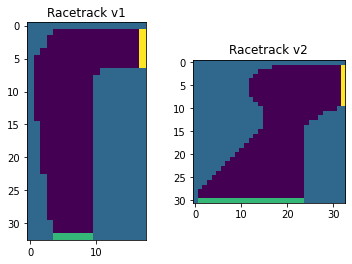

In [4]:
fig, arr = plt.subplots(1, 2)
arr[0].set_title("Racetrack v1")
arr[0].imshow(racetrack_v1_arr)
arr[1].set_title("Racetrack v2")
arr[1].imshow(racetrack_v2_arr)
plt.show()

In [4]:
"""Implementation of the Racetrack environment. Do not change"""
class Racetrack(object):
    def __init__(self, version):
        # Load the pre-defined the domain having the following representation
        #   - 1: track cell
        #   - 0: empty cell
        #   - 2: empty cell on the start line
        #   - 3: empty cell on the finish line
        if version == "v1":
            self.domain_arr = racetrack_v1_arr.copy()
        else:
            self.domain_arr = racetrack_v2_arr.copy()

        # domain size
        self.height, self.width = self.domain_arr.shape

        # State space consists of:
        # Agent location
        self.empty_cell_locs = self.render_cell_locations(val=0.0)
        self.track_cell_locs = self.render_cell_locations(val=1.0)
        self.start_cell_locs = self.render_cell_locations(val=2.0)
        self.finish_cell_locs = self.render_cell_locations(val=3.0)

        # Action space
        self.action_space = [[-1, -1], [-1, 0], [-1, 1],
                             [0, -1], [0, 0], [0, 1],
                             [1, -1], [1, 0], [1, 1]]

        # construct the state space
        self.state_space = []
        for loc in self.start_cell_locs + self.empty_cell_locs + self.finish_cell_locs:
            for i in range(5):
                for j in range(5):
                    self.state_space.append(loc + [i, j])

        # track the agent's location
        self.state = None
        self.action = None
        self.t = None

    def reset(self):
        # randomly select one cell from the start line
        start_loc = random.sample(self.start_cell_locs, 1)[0]
        # reset the velocity to be zero for both x and y directions
        start_vel = [0, 0]
        # the state is a combination of location and velocity
        # for example: [loc_x, loc_y, vel_x, vel_y]
        state = start_loc + start_vel
        # reward
        reward = None
        # done
        done = False
        # track agent's location
        self.state = tuple(state)
        self.t = 0
        return state, reward, done

    def step(self, state, action):
        """
        Args:
            state (list): a list variable consists of agent's location + agent's current velocity. e.g., [x, y, v_x, v_y]
            action (list): a list variable consists of agent's velocity increments. e.g., [increments_v_x, increments_v_y]
        """
        # reward is -1 for every time step until the agent passes the finish line
        reward = -1
        self.t += 1
        
        # with the probability = 0.1, set action = [0, 0]
        if np.random.random() < 0.1:
            action = [0, 0]

        # update the velocity components
        # note that, both velocity is discrete and constraint within [0, 4]
        next_vel_x = np.clip(state[2] + action[0], a_min=0, a_max=4)
        next_vel_y = np.clip(state[3] + action[1], a_min=0, a_max=4)
        next_state_vel = [next_vel_x, next_vel_y]

        # only the cells on the start line can have both 0 velocities
        if next_state_vel == [0, 0]:
            if state not in self.start_cell_locs:
                # non-zero for velocities
                if state[2] == 0 and state[3] != 0:
                    next_state_vel = [0, 1]
                if state[2] != 0 and state[3] == 0:
                    next_state_vel = [1, 0]
                if state[2] != 0 and state[3] != 0:
                    non_zero_idx = random.sample([0, 1], 1)[0]
                    next_state_vel[non_zero_idx] = 1

        # update the next state location based on the updated velocities
        next_state_loc = [np.clip(state[0] + next_state_vel[0], a_min=0, a_max=self.width-1),
                          np.clip(state[1] + next_state_vel[1], a_min=0, a_max=self.height-1)]

        # check whether the agent hits the track
        if next_state_loc in self.track_cell_locs:
            # move back to the start line
            next_state_loc = random.sample(self.start_cell_locs, 1)[0]
            # reduce velocity to be 0s
            next_state_vel = [0, 0]
            # episode continue
            done = False
            # next state
            next_state = next_state_loc + next_state_vel
            return next_state, reward, done

        # check whether the agent pass the finish line
        if next_state_loc in self.finish_cell_locs:
            next_state = next_state_loc + next_state_vel
            done = True
            return next_state, 0, done

        # otherwise combine the next state
        next_state = next_state_loc + next_state_vel
        # termination
        done = False

        # track the agent's state
        self.state = tuple(next_state)
        self.action = action
        return next_state, reward, done

    def render_cell_locations(self, val):
        row_loc_indices, col_loc_indices = np.where(self.domain_arr == val)
        cell_locations = [[c, (self.height-1) - r] for r, c in zip(row_loc_indices, col_loc_indices)]
        return cell_locations

    def render(self):
        plt.clf()
        plt.title(f"s = {self.state}, a = {self.action}")
        plot_arr = self.domain_arr.copy()
        plot_arr[(self.height - 1) - self.state[1], self.state[0]] = 4
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.01)

## (a): Implement first-visit Monte-Carlo control with a epsilon-greedy policy (epsilon = 0.1)
    - Plot the learning curves for the two tracks.
    - Use running trials number = 10 and episodes number = 2000

In [5]:
RUN_NUM = 10
EPISODE_NUM = 2000
GAMMA = 0.9

def get_value(q: np.array, state: List[int], action: int) -> float:
    """Gets q(s, t) given s and t.

    Args:
        q: np array of state action values
        state: current state
        action: index of action

    Returns:
        q(s, a)
    """
    return q[tuple(state + [action])]
    
def add_value(q: np.array, counter: np.array, state: List[int], action: int, value: float) -> Tuple[np.array, np.array]:
    """Updates state action value array with new value

    Args:
        q: np array of state action values
        counter: np array of number of times each state/action pair has been visited
        state: current state
        action: index of action
        value: value to update q with

    Returns:
        q: updated state action value array
        counter: updated counter array
    """
    index = tuple(state + [action])
    counter[index] = counter[index] + 1
    q[index] = (q[index] * (counter[index] - 1) + value) / counter[index]
    return q, counter

def set_policy(policy_arr: np.array, state: List[int], action: int, policy: float) -> np.array:
    """Sets stochastic policy value for state/action pair.

    Args:
        policy_arr: np array of policy where policy_arr[state, action] gives the probability of that action occuring for that state
        state: current state
        action: index of action
        policy: new value for the policy at the state/action pair

    Returns: 
        policy_arr: updated policy array
    """
    policy_arr[tuple(state + [action])] = policy
    return policy_arr

def get_policy(policy_arr: np.array, state: List[int]) -> int:
    """Gets action based on stochastic policy.

    Args:
        policy_arr: np array of policy where policy_arr[state, action] gives the probability of that action occuring for that state
        state: current state

    Returns:
        a: action determined from stochastic policy
    """
    r = np.random.rand()

    chance = 0
    for a in range(policy_arr.shape[-1]):
        chance += policy_arr[tuple(state + [a])]

        if r <= chance:
            return a

def argmax(l: List[float]) -> int:
    """Argmax function with ties broken randomly.

    Args:
        l: list or list-like

    Returns:
        index of max value
    """
    l = np.array(l)
    return np.random.choice(np.flatnonzero(l == l.max()))

def run_mc_e_soft(env: Type[Racetrack], epsilon: float, num_runs: int=RUN_NUM, num_episodes: int=EPISODE_NUM) -> np.array:
    """Runs e-soft MC policy for Racetrack env

    Args:
        env: Racetrack environment
        epsilon: epsilon value to use for policy
        num_runs: number of runs
        num_episodes: number of episodes per run

    Returns:
        results_rewards: np array of discounted reward for each episode
    """
    
    num_actions = len(env.action_space)
    
    results_rewards = np.empty((RUN_NUM, EPISODE_NUM))
    optimal_policy = []
    
    for r in range(num_runs):
        print(f"r: {r}")
        
        # initialize policy to equal chance for everything
        policy = np.ones(list(np.array(env.state_space).max(axis=0) + 1) + [num_actions]) * (1./num_actions)
        q = np.zeros(list(np.array(env.state_space).max(axis=0) + 1) + [num_actions])
        counter = np.zeros(list(np.array(env.state_space).max(axis=0) + 1) + [num_actions])
            
        for e in range(num_episodes):
            
            # store states and rewards for the episode
            state_action_list = []
            reward_list = []
            
            # generate an episode
            state, reward, done = env.reset()
            while not done:
                # find action according to current policy
                action = get_policy(policy, state)
                
                next_s, reward, done, = env.step(state, env.action_space[action])
                
                state_action_list.append((state, action))
                reward_list.append(reward)
        
                state = next_s
        
            g = 0
            t = len(state_action_list)-1
            # loop through states and rewards backwards
            for state_action, reward in zip(state_action_list[::-1], reward_list[::-1]):
                state = state_action[0]
                action = state_action[1]
                
                g = GAMMA*g + reward
        
                if state_action not in state_action_list[:t]: # first-visit
                    q, counter = add_value(q, counter, state, action, g)
    
                    # find optimal action
                    a_star = argmax([get_value(q, state, a) for a in range(num_actions)])
    
                    # update policy 
                    for a in range(len(env.action_space)):
                        if a == a_star:
                            policy = set_policy(policy, state, a, 1-epsilon+(epsilon/num_actions))
                        else:
                            policy = set_policy(policy, state, a, epsilon/num_actions)
                t -= 1
                results_rewards[r, e] = g

    return results_rewards

In [85]:
env = Racetrack('v1')
results_rewards = run_mc_e_soft(env, 0.1)

r: 0
r: 1
r: 2
r: 3
r: 4
r: 5
r: 6
r: 7
r: 8
r: 9


<Figure size 432x288 with 0 Axes>

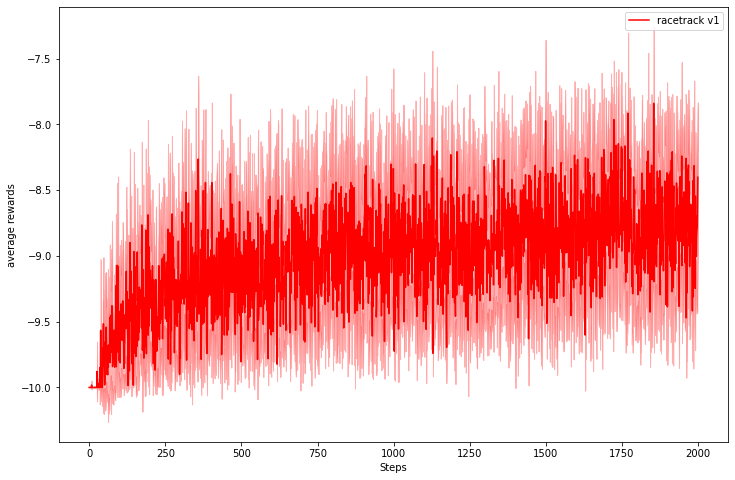

In [86]:
plot_curves([results_rewards], ['racetrack v1'], ['r'], 'average rewards')

In [89]:
env = Racetrack('v2')
results_rewards_v2 = run_mc_e_soft(env, 0.1)

r: 0
r: 1
r: 2
r: 3
r: 4
r: 5
r: 6
r: 7
r: 8
r: 9


<Figure size 432x288 with 0 Axes>

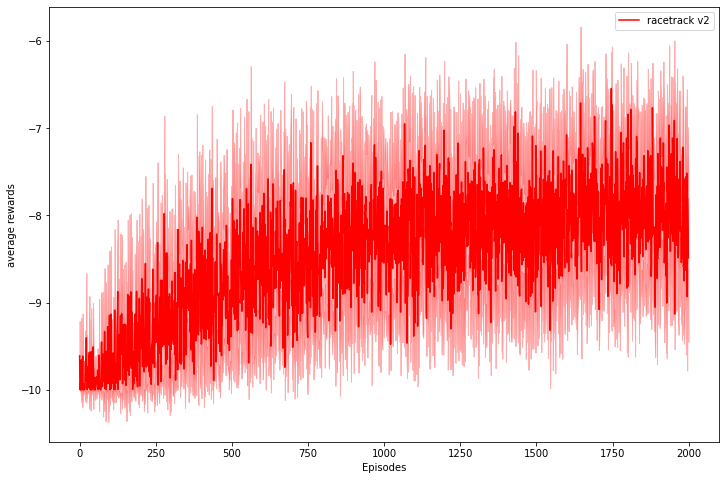

In [90]:
plot_curves([results_rewards_v2], ['racetrack v2'], ['r'], 'average rewards')

plot an episode given policy (used for debugging)

In [72]:
env = Racetrack('v1')

# generate an episode using optimal policy
state, reward, done = env.reset()
state_list = [state]
while not done:
    # find action according to current policy
    action = get_policy(optimal_policy, state)
    
    next_s, reward, done, = env.step(state, env.action_space[action])
    
    state_list.append(next_s)

    state = next_s

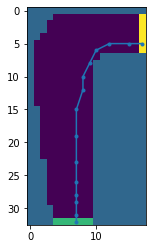

In [73]:
# plot episode of optimal policy execution
plt.imshow(racetrack_v1_arr)
plt.plot(np.array(state_list)[:, 0], 32-np.array(state_list)[:, 1], '.-')

In [78]:
env = Racetrack('v2')

# generate an episode using optimal policy
state, reward, done = env.reset()
state_list = [state]
while not done:
    # find action according to current policy
    action = get_policy(optimal_policy_v2, state)
    
    next_s, reward, done, = env.step(state, env.action_space[action])
    
    state_list.append(next_s)

    state = next_s

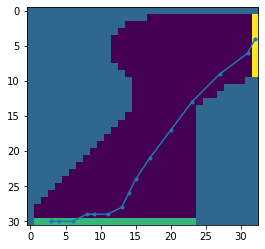

In [79]:
# plot episode of optimal policy execution
plt.imshow(racetrack_v2_arr)
plt.plot(np.array(state_list)[:, 0], 30-np.array(state_list)[:, 1], '.-')

# (b) Off-policy MC control

In [7]:
RUN_NUM = 10
EPISODE_NUM = 2000
GAMMA = 0.9

def get_b_policy(q: np.array, state: List[int], epsilon: float) -> int:
    """Gets action according to policy b (epislon greedy) with ties broken randomly.

    Args:
        q: np array of action value function
        state: current state used to index q
        epsilon: epsilon value for policy b

    Returns:
        index of action according to policy b
    """
    r = np.random.rand()

    if r < epsilon:
        return np.random.randint(q.shape[-1])
    else:
        return argmax(q[tuple(state)])

def argmax(l: List[float]) -> int:
    """Argmax function with ties broken randomly.

    Args:
        l: list or list-like

    Returns:
        index of max value
    """
    l = np.array(l)
    return np.random.choice(np.flatnonzero(l == l.max()))

def run_off_policy(env: Type[Racetrack], epsilon: float, num_runs: int=RUN_NUM, num_episodes: int=EPISODE_NUM) -> Tuple[np.array, List[List[Tuple[List[int], int]]]]:
    """Runs off-policy MC for Racetrack env.

    Args:
        env: Racetrack environment
        epsilon: epsilon value to use for policy b
        num_runs: number of runs
        num_episodes: number of episodes per run

    Returns:
        results_rewards: np array of discounted reward for each episode
        episodes: list of (list of state/action tuples) for each episode, for the first run
    """

    num_actions = len(env.action_space)
    
    results_rewards = np.empty((num_runs, num_episodes))
    episodes = []
    optimal_policy = None
    
    for r in range(num_runs):
        print(f"r: {r}")

        # set q to negative number to discourage exploration and help converge faster
        q = np.ones(list(np.array(env.state_space).max(axis=0) + 1) + [num_actions]) * (-100)
        c = np.zeros(list(np.array(env.state_space).max(axis=0) + 1) + [num_actions])
    
        # initialize policy argmax q with ties broken consistently
        policy = np.argmax(q, axis=4)
            
        for e in range(num_episodes):
            
            # store states and rewards for the episode
            state_action_list = []
            reward_list = []
            
            # generate an episode
            state, reward, done = env.reset()
            while not done:
                # find action according to b policy
                action = get_b_policy(q, state, epsilon)
                
                next_s, reward, done, = env.step(state, env.action_space[action])
                
                state_action_list.append((state, action))
                reward_list.append(reward)
        
                state = next_s
        
            g = 0
            w = 1
            t = len(state_action_list)-1
            # loop through states and rewards backwards
            for state_action, reward in zip(state_action_list[::-1], reward_list[::-1]):
                state = state_action[0]
                action = state_action[1]
                
                g = GAMMA*g + reward
                index = tuple(state + [action])

                # first-visit only
                if state_action in state_action_list[:t]:
                    continue
                
                c[index] = c[index] + w
                q[index] = q[index] + (w/c[index]) * (g - q[index])
                policy[tuple(state)] = np.argmax(q[tuple(state)])
    
                # update weight if action is optimal
                if action == policy[tuple(state)]:
                    w = w / ((1-epsilon) + epsilon/num_actions) # probability of optimal action from epsilon greedy policy
                else:
                    break

                t -= 1

            # generate episode to track rewards
            state, reward, done = env.reset()
            reward_list = []
            for _ in range(500): # timeout since early policies may never finish
                # find action according to policy
                action = policy[tuple(state)]
                
                next_s, reward, done, = env.step(state, env.action_space[action])
                
                reward_list.append(reward)
        
                state = next_s

                if done:
                    break
            results_rewards[r, e] = sum(np.array(reward_list) * np.array([GAMMA**i for i in range(len(reward_list))]))
        
        if r == 0:
            optimal_policy = policy

    return results_rewards, optimal_policy

In [178]:
env = Racetrack('v1')
results_rewards_off_policy, optimal_policy = run_off_policy(env, 0.1)

r: 0
r: 1
r: 2
r: 3
r: 4
r: 5
r: 6
r: 7
r: 8
r: 9


<Figure size 432x288 with 0 Axes>

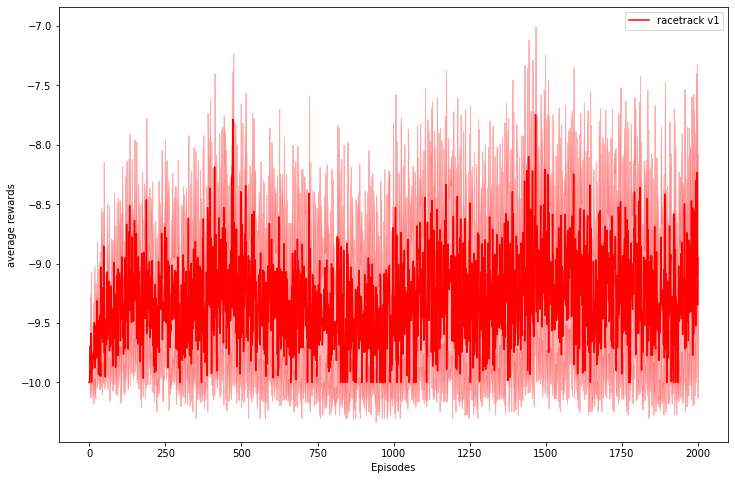

In [179]:
plot_curves([results_rewards_off_policy], ['racetrack v1'], ['r'], 'average rewards')

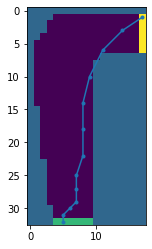

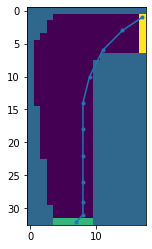

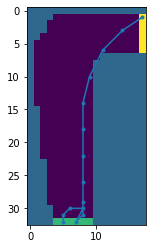

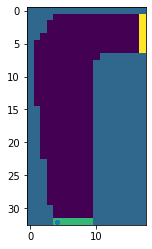

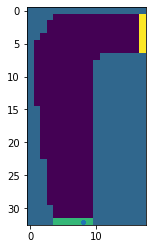

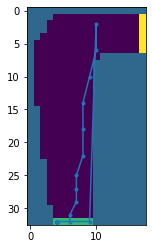

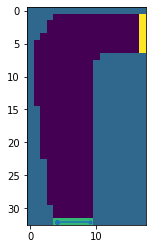

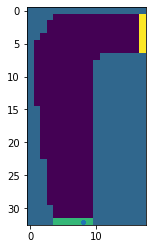

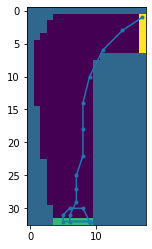

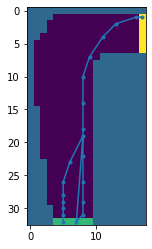

In [205]:
# plot rolled out policy
env = Racetrack('v1')

for _ in range(10):
    # generate an episode using optimal policy
    state, reward, done = env.reset()
    state_list = [state]
    reward_list = []
    for _ in range(1000):
        # find action according to current policy
        action = episodes[tuple(state)]
        
        next_s, reward, done, = env.step(state, env.action_space[action])
        
        state_list.append(next_s)
        reward_list.append(reward)
    
        state = next_s

        if done:
            break
    # plot episode of optimal policy execution
    plt.imshow(racetrack_v1_arr)
    plt.plot(np.array(state_list)[:, 0], 32-np.array(state_list)[:, 1], '.-')
    plt.show()

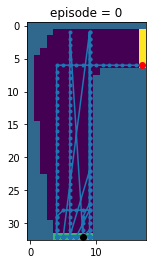

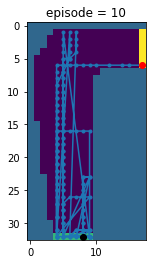

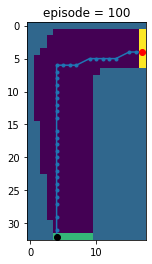

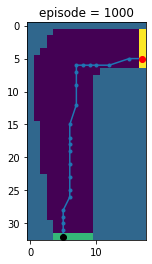

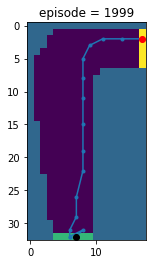

In [24]:
for num in [0, 10, 100, 1000, 1999]: # plot specific episodes
    states = []
    states = [s for s, _ in episodes[num]]
    
    plt.imshow(racetrack_v1_arr)
    plt.plot(np.array(states)[:, 0], 32-np.array(states)[:, 1], '.-')
    plt.plot(np.array(states)[0, 0], 32-np.array(states)[0, 1], 'ko')
    plt.plot(np.array(states)[-1, 0], 32-np.array(states)[-1, 1], 'ro')
    plt.title(f"episode = {num}")
    plt.show()

In [191]:
env = Racetrack('v2')
results_rewards_off_policy_v2, optimal_policy_v2 = run_off_policy(env, 0.1)

r: 0
r: 1
r: 2
r: 3
r: 4
r: 5
r: 6
r: 7
r: 8
r: 9


<Figure size 432x288 with 0 Axes>

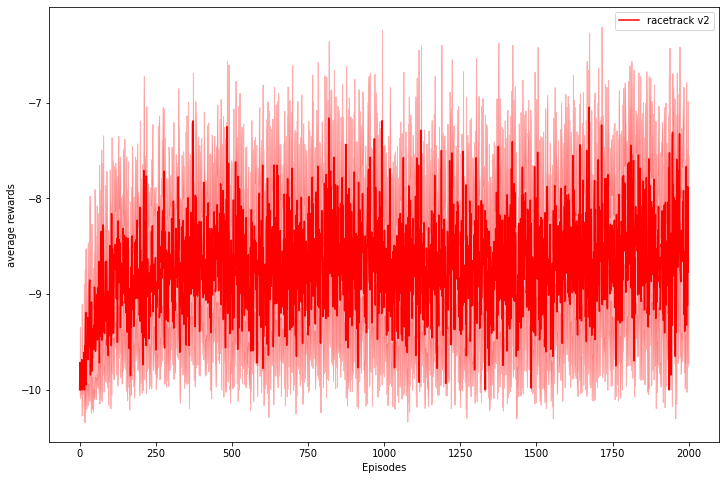

In [192]:
plot_curves([results_rewards_off_policy_v2], ['racetrack v2'], ['r'], 'average rewards')

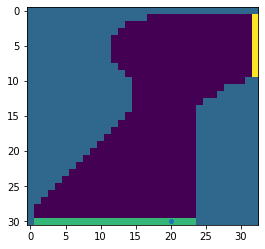

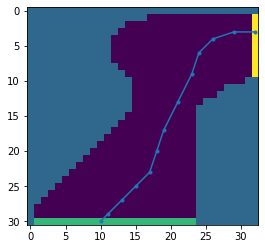

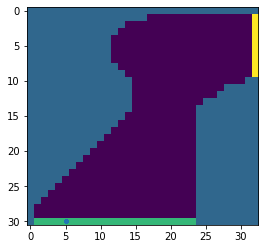

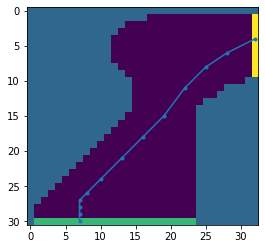

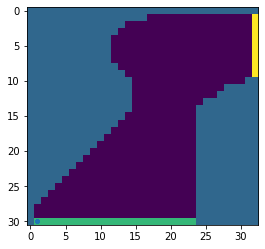

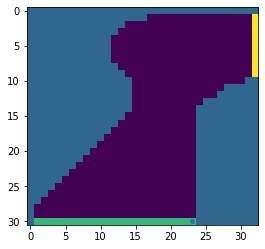

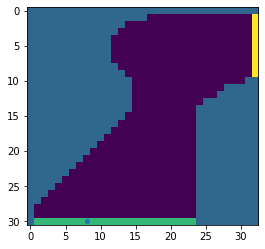

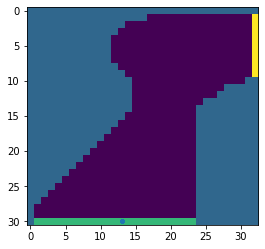

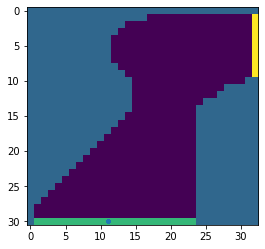

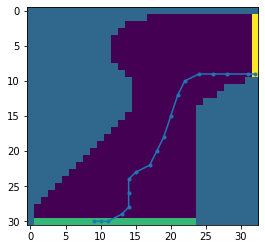

In [209]:
# plot rolled out policy
env = Racetrack('v2')

for _ in range(10):
    # generate an episode using optimal policy
    state, reward, done = env.reset()
    state_list = [state]
    reward_list = []
    for _ in range(1000):
        # find action according to current policy
        action = optimal_policy_v2[tuple(state)]
        
        next_s, reward, done, = env.step(state, env.action_space[action])
        
        state_list.append(next_s)
        reward_list.append(reward)
    
        state = next_s

        if done:
            break
    # plot episode of optimal policy execution
    plt.imshow(racetrack_v2_arr)
    plt.plot(np.array(state_list)[:, 0], 30-np.array(state_list)[:, 1], '.-')
    plt.show()

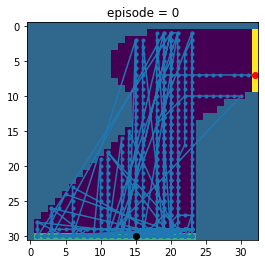

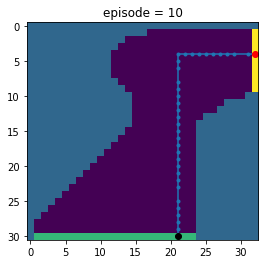

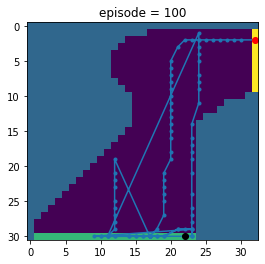

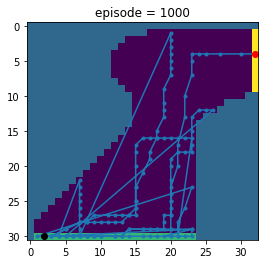

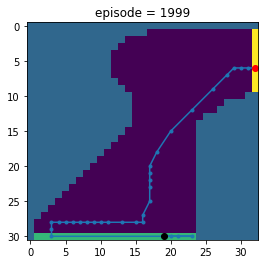

In [40]:
for num in [0, 10, 100, 1000, 1999]: # plot specific episodes
    states = []
    states = [s for s, _ in episodes_v2[num]]
    
    plt.imshow(racetrack_v2_arr)
    plt.plot(np.array(states)[:, 0], 30-np.array(states)[:, 1], '.-')
    plt.plot(np.array(states)[0, 0], 30-np.array(states)[0, 1], 'ko')
    plt.plot(np.array(states)[-1, 0], 30-np.array(states)[-1, 1], 'ro')
    plt.title(f"episode = {num}")
    plt.show()

# 1 (c)

In [5]:
class S:
    def __init__(self):
        self.action_space = ["left", "right"]
        self.state_space = [0, 1] # use 0 for s and 1 for terminal
        self.state = 0
        
    def reset(self):
        self.state = 0

    def step(self, action):
        if action not in self.action_space:
            raise ValueError("invalid action")

        next_s = 0
        reward = 0
        done = False

        if action == "right":
            next_s = 1
            done = True
        else:
            r = np.random.rand()
            if r < 0.1:
                next_s = 1
                reward = 1
                done = True

        self.state = next_s
        return reward, done

In [6]:
def run_1c(run_num, episode_num):
    s = S()
    
    value_arr = []
    for _ in range(run_num): # number of runs
        numerator = 0
        tau_len = 0
        value_arr_run = []
        
        for _ in range(episode_num):
            s.reset()
            done = False
            
            episode_len = 0
            episode_reward = 0
            
            while not done:
                episode_len += 1 # counter of number of times non-terminal state was reached in episode
                action = np.random.choice(['left', 'right']) # follow b-policy to choose at random
                reward, done = s.step(action)
            
                episode_reward = reward # track reward for episode (no discounting)
        
            numerator += np.sum((1/.5) ** np.array(range(1, episode_len+1)) * episode_reward) # numerator of v for current episode, keep sum over episodes
            tau_len += episode_len # denominator of v = total number of times non-terminal state was reached
            v = numerator / tau_len
            
            value_arr_run.append(v)
        value_arr.append(value_arr_run)

    return value_arr

In [ ]:
# jupyter would crash when running too many episodes or runs so capped at 1e6

In [13]:
v = run_1c(1, int(1e6))

In [14]:
v2 = run_1c(1, int(1e6))

In [15]:
v3 = run_1c(1, int(1e6))

In [16]:
v4 = run_1c(1, int(1e6))

In [17]:
v5 = run_1c(1, int(1e6))

In [18]:
v6 = run_1c(1, int(1e6))

In [19]:
v7 = run_1c(1, int(1e6))

In [20]:
v8 = run_1c(1, int(1e6))

In [21]:
v9 = run_1c(1, int(1e6))

In [22]:
v10 = run_1c(1, int(1e6))

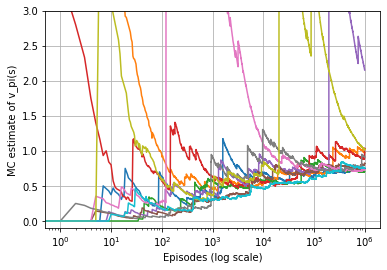

In [25]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.grid()
ax.set_xlabel('Episodes (log scale)')
ax.set_ylabel('MC estimate of v_pi(s)')
ax.set_ylim([-.1, 3])
for arr in [v, v2, v3, v4, v5, v6, v7, v8, v9, v10]:
    ax.plot(arr[0])